# Transfer Learning Example: Adapting a Pre-Trained Convolutional Neural Network for Custom Image Classification


Transfer learning involves taking a model that has been trained on one task and applying it to a different but related task. This technique is useful because it allows a model to leverage knowledge (features, weights, and biases) from the original task, which can often improve learning efficiency and prediction performance on the new task.


_**Our task in the following is to reuse a neural network that has been trained on a different image classification problem to solve another one.**_


## New Clasification Task & Dataset


We are going to use [**Oxford Flowers102**](https://paperswithcode.com/dataset/oxford-102-flower) dataset, which contains images of 102 different types of flowers. The size of the dataset is about 700 MB.


In [1]:
import tensorflow_datasets

dataset, dataset_info = tensorflow_datasets.load(
    "oxford_flowers102",
    as_supervised=True,
    with_info=True,
    split=["train", "test", "validation"],
)

# Unpack the dataset
train_data, test_data, validation_data = dataset

/Users/cls/miniforge3/envs/ai-on-a-microbudget/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's have a look into the images and their class labels.

In [2]:
n_classes = 102

# Assuming 'class_names' is a list of flower names corresponding to label indices
class_names = dataset_info.features['label'].names

In [3]:
import matplotlib.pyplot as plt

In [4]:

def display_images_with_labels(dataset, class_names, num_samples=5):
    """
    Display a grid of images and their labels.

    Parameters:
    - dataset: tf.data.Dataset - The dataset from which to take the samples.
    - class_names: list - A list of class names corresponding to the label indices.
    - num_samples: int - The number of samples to display.
    """
    plt.figure(figsize=(10, 2 * num_samples))  # Adjust figure size based on the number of samples

    # Take 'num_samples' samples from the dataset
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)  # Create a subplot for each sample
        ax.imshow(image.numpy().astype("uint8"))  # Convert to uint8 type if necessary
        ax.set_title(f"Label: {class_names[label.numpy()]}")
        ax.axis("off")  # Hide the axes

    plt.tight_layout()  # Adjust layout so images are neatly displayed
    plt.show()


2024-05-21 18:45:30.510191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


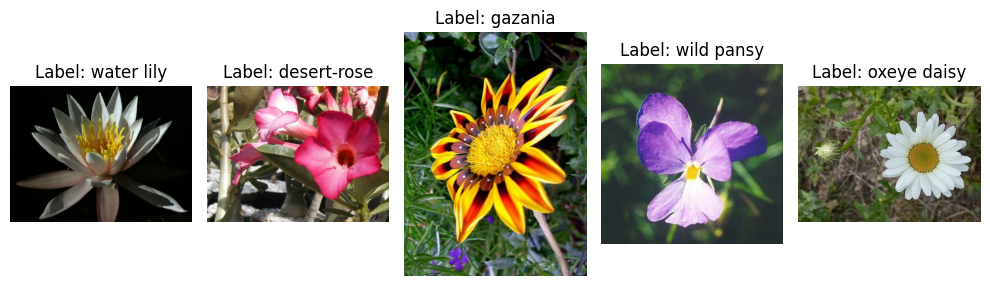

In [5]:

display_images_with_labels(train_data, class_names, num_samples=5)

## Why Transfer Learning?

A quick internet search did not give us a pre-trained model for this particular flower classification problem. So we need to train our own. But do we need to train it from scratch? Training an image classifier, often a convolutional neural network, may take significant compute time. 

Can we do more with less? Yes, we can reuse most parts of a network that has already been trained on a large image dataset, and only retrain the final layer(s) for our specific task. This approach is a classic example of transfer learning.

Transfer learning works well for image classification problems because the early layers of a CNN learn to detect generic features like edges, textures, and patterns, which are relevant across various image domains. The later layers learn more specific features tailored to the task at hand. By leveraging a pre-trained model, we can benefit from the knowledge it has already acquired and adapt it to our specific problem with minimal retraining.

This allows us to achieve good performance with less data and computation, as we only need to train the last layer(s) instead of training the entire network from scratch.

<div align="center">
    <img src="img/Visualization-of-Transfer-Learning-4.jpg" alt="Visualization of Transfer Learning" style="max-width:100%; height:auto ;"/>
    <br>
    <figcaption style="color: gray;">Source: <a href="https://www.researchgate.net/figure/Visualization-of-Transfer-Learning-4_fig5_331983081">A Study Review: Semantic segmentation with Deep Neural Networks</a></figcaption>
</div>

## Getting a Pretrained Model


_MobileNetV2_ is a good choice as a base model for transfer learning because it is lightweight, computationally efficient, and has been pre-trained on a large dataset.

It has been pre-trained on the ImageNet dataset, which contains over 1.4 million images across 1,000 classes. This diverse and large-scale dataset allows MobileNetV2 to learn a wide range of features that can be effectively transferred to other image classification tasks.

Its compact architecture makes it suitable for mobile and resource-constrained environments while still achieving good performance. By leveraging MobileNetV2's pre-learned features, we can quickly adapt it to our specific task with minimal re-training.

<div align="center">
    <img src="img/The-visual-structure-of-MobileNetV2-18860668.png" style="max-width:100%; height:auto;"/>
    <br>
    <figcaption style="color: gray;">MobileNetV2 architecture visualized (<a href="https://www.researchgate.net/figure/The-visual-structure-of-MobileNetV2_fig3_356354780">Source</a>)</figcaption>
</div>

In [6]:
from tensorflow import keras

With the help of `keras` we obtain the pre-trained model. Note the following arguments:

- `input_shape=(224, 224, 3)`: Specifies the expected input shape of the images. Here, the images will be resized to 224x224 pixels with 3 color channels (RGB).
- `include_top=False`: Excludes the fully connected layer at the top of the network. This allows us to customize the final layer(s) for our specific classification task.
- `weights="imagenet"`: Initializes the model with pre-trained weights from the ImageNet dataset, enabling transfer learning.

In [7]:
# Load MobileNetV2 without the top layer
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

In [8]:


base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Prepare Dataset for Training


The following code prepares the image data for training, validation, and testing:

- The preprocessing function resizes images and normalizes pixel values.
- The labels are converted to one-hot encoded format, since the network architecture expects this.
- The training, validation, and test data pipelines apply preprocessing, shuffle the training data, batch the data, and use prefetching to optimize data loading.
- These steps ensure the data is in the correct format and efficiently loaded during model training and evaluation.

In [9]:
import tensorflow as tf

In [10]:
def preprocess(image, label):
    # Resize and normalize the images
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=n_classes)  # Convert labels to one-hot
    return image, label


# Apply preprocessing, shuffle, batch, and prefetch to optimize loading
train_data = (
    train_data
    .map(preprocess)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
validation_data = (
    validation_data
    .map(preprocess)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
test_data = (
    test_data
    .map(preprocess)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [11]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))>

In [12]:
validation_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))>

In [13]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))>

In [14]:
import tensorflow as tf

# Assuming `train_data` is your dataset
for images, labels in train_data.take(1):
    print("Label examples:", labels.numpy())
    print("Shape of labels:", labels.shape)
    print("Batch shape:", images.shape)

Label examples: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of labels: (32, 102)
Batch shape: (32, 224, 224, 3)


2024-05-21 18:45:31.648484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Assemble Model for Transfer Learning


We now assemble the new model to be trained on flower classification. 

First, we "freeze" the weights in the base model - the convolutional part of the network - so they are unaffected by training. We want to reuse them.

In [15]:
base_model.trainable = False  # Freeze the convolutional base

Our network needs a new classification head. The original model has an output layer for 1000 classes  by default - change it to the number of flower types.


In [16]:
# Create a new model on top of the output of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation='softmax') 
])

Finally we compile the model to set it up for training. As performance metrics, we look at _accuracy_, _precision_ and _recall_.

In [17]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)

### Training

Let's train the model. We can expect the training to be much faster since only the weights of the classification head need to be adjusted.

In [18]:
n_epochs = 25

In [19]:
# Fit the model on the training data
history = model.fit(
    train_data,
    epochs=n_epochs,  # You can adjust the number of epochs based on the training performance
    validation_data=validation_data,
)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 389ms/step - accuracy: 0.0267 - loss: 4.8340 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2127 - val_loss: 4.0396 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 358ms/step - accuracy: 0.1860 - loss: 3.8048 - precision: 0.4394 - recall: 0.0038 - val_accuracy: 0.3804 - val_loss: 3.0258 - val_precision: 1.0000 - val_recall: 0.0353
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.3588 - loss: 2.7605 - precision: 0.9461 - recall: 0.0819 - val_accuracy: 0.5833 - val_loss: 2.2067 - val_precision: 0.9752 - val_recall: 0.1157
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.5534 - loss: 1.9017 - precision: 0.9044 - recall: 0.2081 - val_accuracy: 0.6500 - val_loss: 1.7050 - val_precision: 0.9958 - val_recall: 0.2314
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.6709 - loss: 1.4371 - precision: 0.9202 - recall: 0.3388 - val_accuracy: 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Convert the history.history dict to a pandas DataFrame
    history_df = pd.DataFrame(history.history)
    
    # Use the 'plot' method to plot the DataFrame, one column vs. the index
    history_df.plot(figsize=(10, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.title('Training and Validation Loss and Accuracy')
    plt.show()


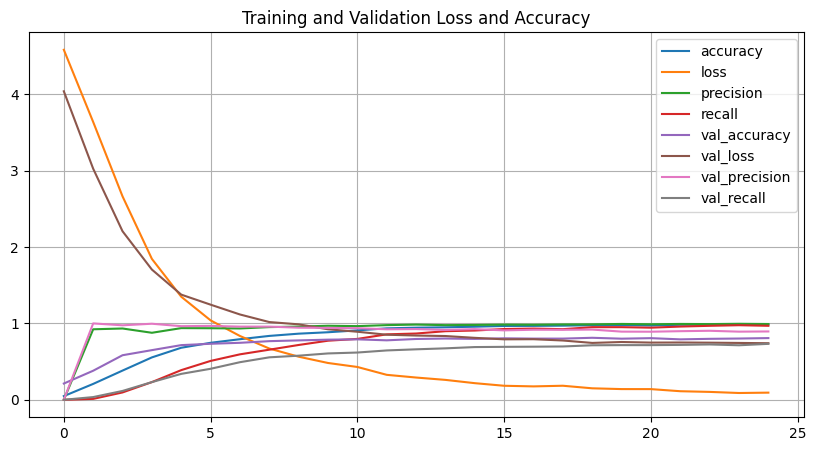

In [21]:
plot_training_history(history)

### Evaluation

Let's see how well our new model does in terms of metrics...

In [22]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)

# Calculate F1 Score
if test_precision + test_recall > 0:
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1_score = None  # Handle case where F1 score cannot be calculated

# Create a DataFrame
results_df = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [
        test_loss,
        test_accuracy,
        test_precision,
        test_recall,
        test_f1_score
    ]
})

results_df

193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 255ms/step - accuracy: 0.7812 - loss: 0.8349 - precision: 0.8873 - recall: 0.7168


,Metric,Value
0,Loss,0.852476
1,Accuracy,0.779314
2,Precision,0.883122
3,Recall,0.713937
4,F1 Score,0.789568


... and let's have a look at a sample of the image set:

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def display_sample_predictions(model, dataset, class_names):
    plt.figure(figsize=(12, 10))
    
    # Take a single batch from the dataset
    for images, labels in dataset.shuffle(100).take(1):
        predictions = model.predict(images)
        
        # Reverse the normalization, assuming the images were normalized to [0, 1]
        images = images * 255
        
        for i in range(9):  # Display the first 9 images and predictions
            ax = plt.subplot(3, 3, i + 1)
            # Clip the values to be in the range [0, 255] and convert to integers
            img = tf.clip_by_value(images[i], 0, 255).numpy().astype("uint8")
            
            plt.imshow(img)
            predicted_label = class_names[np.argmax(predictions[i])]
            
            # Check if labels are one-hot encoded or integers
            if labels.ndim == 2:  # One-hot encoded
                true_label_index = np.argmax(labels[i])
            else:  # Integer labels
                true_label_index = labels[i]
                
            true_label = class_names[true_label_index]
            
            plt.title(f"Predicted: {predicted_label},\n True: {true_label}")
            plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


2024-05-21 18:52:26.797869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


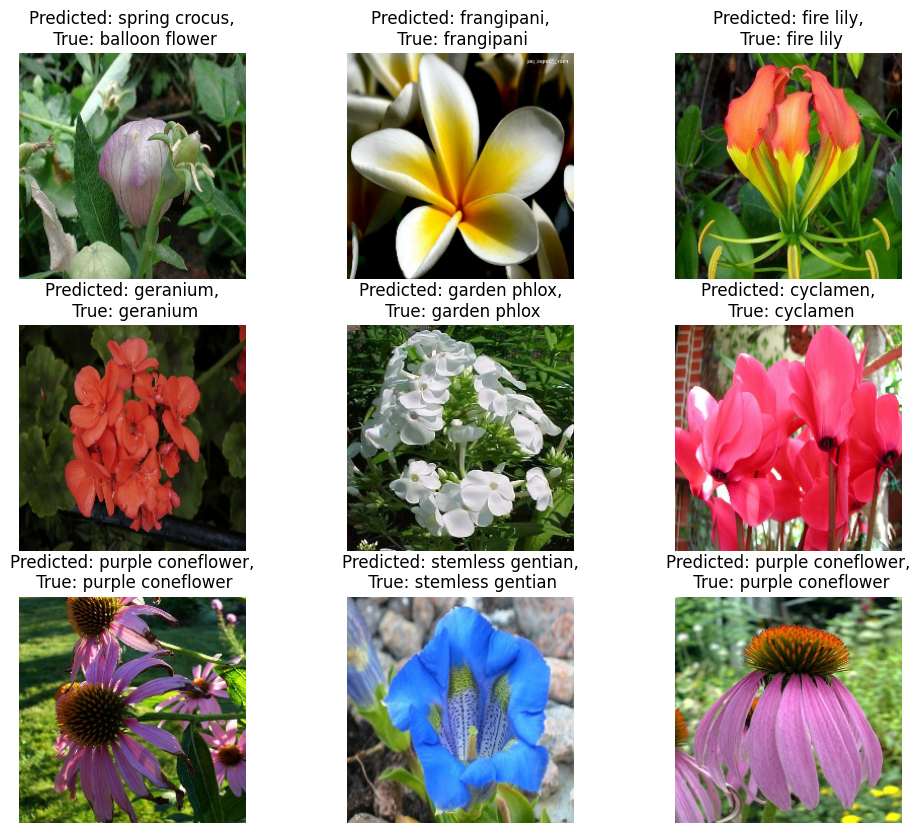

In [24]:
# Assuming 'class_names' is a list of flower names corresponding to label indices
class_names = dataset_info.features['label'].names

# Display predictions
display_sample_predictions(model, test_data, class_names)

## Conclusion

This simple workflow is a demonstration of how we can obtain a pretty good image classifier for a new classification tasks with minimal training resources. Neural networks are mostly feature extractors, so learning makes it possible to reuse that knowledge.

### Saving the Model for Later Use

We are going to reuse this model. This is how to save it to disk.

In [25]:
from pathlib import Path

model_dir = Path("../models/tmp")

# Assuming 'model' is your Keras model
model.save(model_dir / "flowers-classifier-tl.keras")


---

_This notebook is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/). Copyright © 2024 [Christian Staudt](https://clstaudt.me), [Katharina Rasch](https://krasch.io)_
